# <h1><center>*Predicting Home Prices*</center></h1>

# Goals:

 - Identify what drives home values
 - Build a model to best predict home values
 ___

# Imports

In [1]:
import pandas as pd
import numpy as np

import acquire as a
import prepare as p
import explore as e
import modeling as m

import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 

import warnings
warnings.filterwarnings("ignore")

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through Sequel Ace from the Codeup database.
 - Wrote a function in my acquire.py file that includes a sql query to extract the data
 - It contained 56,079 rows and 12 columns before cleaning
 - Each row represents a home in this zillow dataset
 - Each column represents a feature of the dataset 
 
 __________

# Prepare

 - Removed columns that were not useful, made a column
 - Checked for nulls in the data
 - Checked that column data types were appropriate
 - Renamed columns
 - Removed Outliers
 - Encoded variables that would promote useability for my models
 - Created dummy variables for categorical variables
 - Added dummy variables to dataset
 - Split data into train, validate and test (approx. 70/15/15)
 
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| :---------------: | :------------------: |
|      home_value      | price of the house |

| Feature  | Definition |
| :-------------: | :-------------: |
| year_built | The year the house was built  |
| lot_sqft | The square feet of the lot  |
| long | The longititude coordinates of the house |
| lat | The latitude coordinates of the house |
| transaction_month | The month of the transaction date |
| bathrooms | Number of bathrooms in the house | 
| bedrooms | Nummber of bedrooms in the house |
| fips | Code identifier for county |
| sqft | Square feet of the property|
| county | Name of the county the house is located |



_____

# A brief look at the data

In [2]:
# acquiring and cleaning the data
df = a.get_zillow_data()
df = p.clean_zillow_data(df)

# splitting data into train, validate, and test
train, validate, test = p.train_val_test(df)

In [3]:
#displaying all columns and getting first 5 rows
train.head()

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
7495,1970.0,2590.0,-0.047247,-118043371.0,33782307.0,2,2.5,3.0,6059.0,2197.0,447926.0,orange
7012,1951.0,7809.0,0.081372,-118119969.0,33952421.0,2,2.0,4.0,6037.0,1580.0,319237.0,los angeles
48548,1955.0,6233.0,-0.009609,-118390504.0,33806526.0,8,2.0,4.0,6037.0,1732.0,166181.0,los angeles
33836,1988.0,7641.0,-0.184504,-118827889.0,34218797.0,6,3.0,4.0,6111.0,2728.0,648910.0,ventura
4448,1923.0,4484.0,0.158148,-118281846.0,34101547.0,1,1.0,3.0,6037.0,1268.0,373120.0,los angeles


# A summary of the data

In [4]:
# a look at our column names, data types, and null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36128 entries, 7495 to 47845
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_built         36128 non-null  float64
 1   lot_sqft           36128 non-null  float64
 2   logerror           36128 non-null  float64
 3   long               36128 non-null  float64
 4   lat                36128 non-null  float64
 5   transaction_month  36128 non-null  int64  
 6   bathrooms          36128 non-null  float64
 7   bedrooms           36128 non-null  float64
 8   fips               36128 non-null  float64
 9   sqft               36128 non-null  float64
 10  home_value         36128 non-null  float64
 11  county             36128 non-null  object 
dtypes: float64(10), int64(1), object(1)
memory usage: 3.6+ MB


# Explore

### *1. Will more bedrooms and bathrooms drive house value up?*

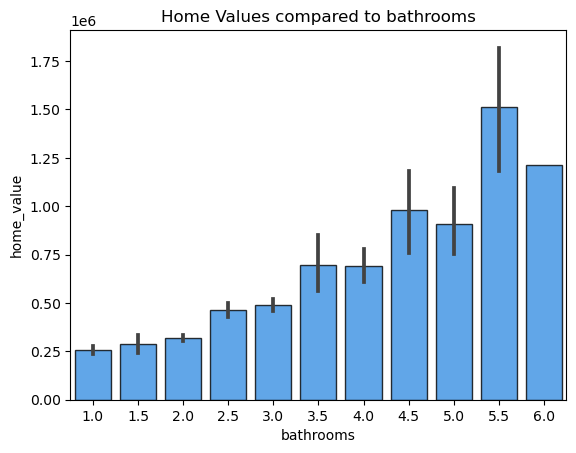

In [5]:
# a bar plot showing us bathrooms compared to their respective home prices
e.plot_categorical_and_continuous_vars(df, 'bathrooms', 'home_value')

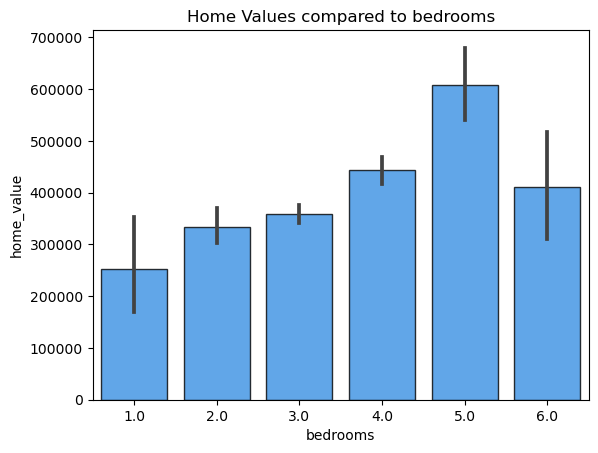

In [6]:
# a bar plot showing us bedrooms compared to their respective home prices
e.plot_categorical_and_continuous_vars(df,'bedrooms', 'home_value')

**Takeaways**

- As bedrooms and bathrooms increase in a home, it seems like the price of the home increase

____

### *2. Does lot size sqft increase home value?*

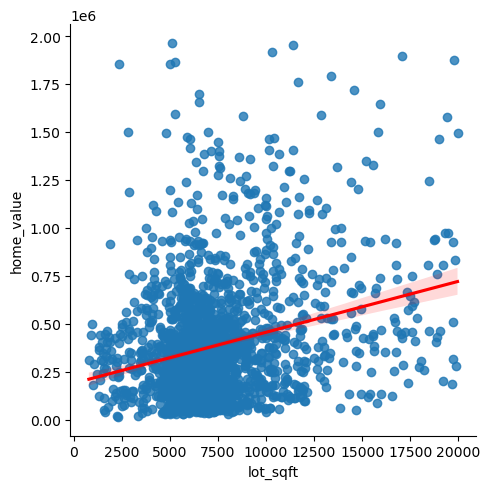

In [7]:
# # a scatter plot showing us a relationship between lot sqft to home prices
e.lm_plot(df)

**Takeaways**

- It seems like as lot sqft goes up so does the price, but the correlation does not seem to be strong


--------

### *3. Does the month of the transaction affect the price of the home?*

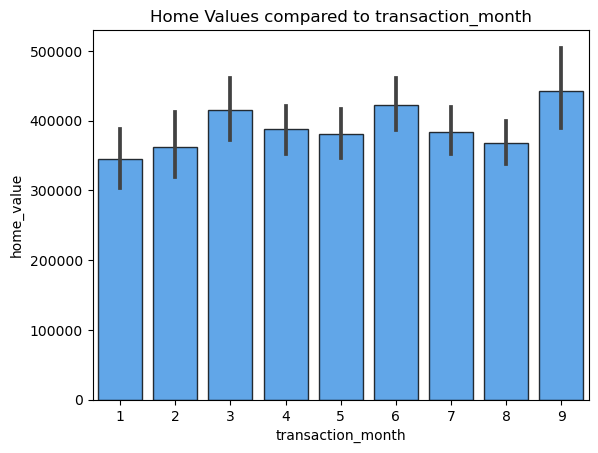

In [28]:
# a bar plot showing us the transaction months to home prices
e.plot_categorical_and_continuous_vars(df, 'transaction_month', 'home_value')

**Takeaways**

- It seems like September had the highest home price value followed by June.

**Ran a pearsonr test to evaluate if there is relationship between transaction month and house value** <br>

$H_0$: There is no relationship between home price and the month of the transaction<br>
$H_a$: There is a relationship between the month of the transaction of the home and the price

 - Confidence interval of 95%
 - Alpha is .05


**Takeaways**

- We reject the null hypothesis, meaning there is a relationship between transaction date and home value. Transaction date will be moved forward for modeling

_____

### *4. Are Orange County home values higher compared to Los Angeles and Ventura County home values?*


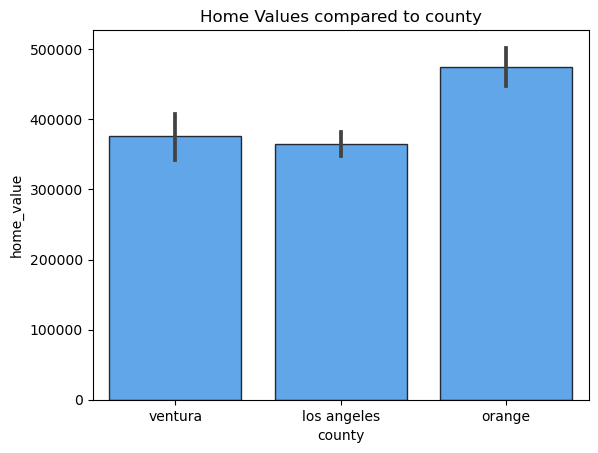

In [9]:
# a bar plot showing us counties to home prices
e.plot_categorical_and_continuous_vars(df, 'county', 'home_value')

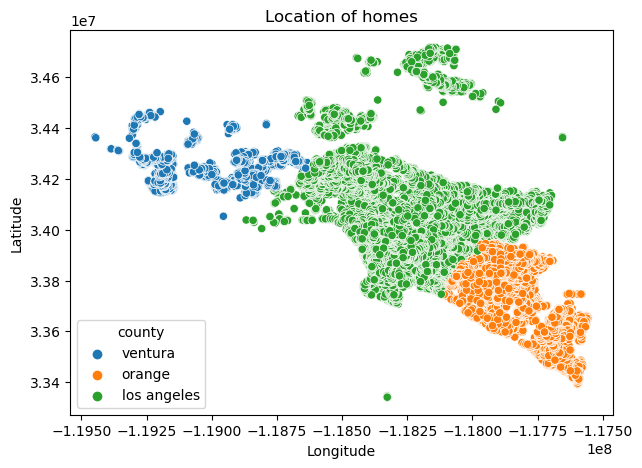

In [10]:
# a scatter plot using latitude and longitude to map out homes in their counties
e.outline(df)

**Takeaways**

- It seems like Orange County homes are more expensive than the other two counties

**Ran a one sample t test to evaluate if Oragne County Homes are more expensive than Los Angeles and Ventura** <br>

$H_0$: Orange County home values are <= Los Angeles and Ventura home values<br>
$H_a$: Orange County home values are > than Los Angeles and Ventura home values

 - Confidence interval of 95%
 - Alpha is .05


In [11]:
# calling a function from explore.py to run a one sample t test
e.county_stats_test(train)

Fail to reject the Null Hypothesis. Findings suggest there is greater home values in Orange County homes than homes in LA or Ventura


**The p-value is more than the Alpha. Therefore, we have strong support that Orange County homes are greater in value compared to Los Angeles and Ventura.**

----

# Exploration Summary

**- Bedrooms, bathrooms, lot sqft, transaction month, and county were found to be features that affect the home value**<br>
**- All features will be added for the modeling phase<br>**
**- County and transaction month seem to have the strongest influence.**
 
 ------

# Modeling 

- Goal is to minimize RMSE, so this will be my evaluation metric
- Ran 3 models including a Linear Regression , LassoLars, and a Polynomial 
- Before modeling scaled data and split
- I evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

In [12]:
# wrote a function to scale my train, validate, and test data subsets
train_scaled, validate_scaled, test_scaled = m.mvp_scaled_data(train, validate, test)

In [13]:
# looking at one line of data in our scaled data
train_scaled.head(1)

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
7495,1970.0,0.107251,0.464608,0.742431,0.320542,2,2.5,3.0,6059.0,0.234005,447926.0,orange


In [14]:
# calling a function I wrote in my modeling.py to split my data in to X/y train, validate, test
X_train, y_train, X_validate,y_validate, X_test, y_test = m.splitting_subsets(train, train_scaled, validate_scaled, test_scaled)

In [15]:
# a look to 1st observation of our scaled, split, train subset
X_train.head(1)

,lot_sqft,logerror,long,lat,sqft,transaction_month_1,transaction_month_2,transaction_month_3,transaction_month_4,transaction_month_5,...,bathrooms_6.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,county_los angeles,county_orange,county_ventura
7495,0.107251,0.464608,0.742431,0.320542,0.234005,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
# called my function that in my modeling.py to demostrate my 3 best models and the baseline
# this includes the train rmse, validate rmse, and their difference 

m.best_models(X_train, y_train, X_validate, y_validate)

,model,train_rmse,validate_rmse,difference
0,linear_poly,217387.134096,217131.473506,255.660590
1,lasso,235229.309282,234879.860188,349.449094
2,linear,235269.845860,234896.009192,373.836668
3,baseline,298539.592323,298539.592323,0.000000


### Modeling Summary & Evaluation 

**The best performing model is the linear polynomial, so we tested the model with the test data**

In [17]:
# this is the best model and ran the test data on it
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,train_rmse,validate_rmse,test_rmse
0,linear_poly,217387.134096,217131.473506,217642.494366


------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>
<br>        
</header>
    
<dl>
<dt>Home value predictions were used by minimizing RMSE within our models. County and transaction month have proven to be the most valuable, but there is still room for improvement.
<br>
            
Best Model's performance:

- My best model reduced the root mean squared error by 82500 dollars compared to the baseline results.

- RMSE 82493.41 dollars on in-sample (train), RMSE 84100.76 dollars on out-of-sample data (validate) and RMSE of 80897.87 dollars on the test data.</dt>
<br>

<header>
    <h2>Recommendations:</h2>
<br>        
</header>  
    
<dl>
<dt> 

- I would recommend using counties and transaction months to build models to predict home values. 

- I would also recommend collecting more data about the homes. For example, crime rates in the county, average salary within neighborhoods, and school rankings.

</dt>   

<header>
    <h2> Next Steps:</h2>       
</header> 
</dl>
    
- I would add more columns/features from the database to see if there are better relationships to help predict price.

- Consider adding different hyperparameters to models for better results.</dl>    

</div>